# Setup

In [1]:
import pandas as pd  # Data handling
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
from pyvbmc import VariationalPosterior
from pyvbmc.priors import SplineTrapezoidal
from scipy.optimize import minimize
import scipy.stats as scs

# Differential equation to be solved
def diffyqs(X, t, a, b):
    xdot,x = X
    dx = xdot
    dv = -x - np.sign(x) * a * np.abs(x)**b
    return [dv, dx]

# time array for solution
dt = 0.05
tf = 10
t = np.arange(0,tf,dt)

# Range of values that parameters can take on
a_min = 0.0
a_max = 0.5
b_min = 1.0
b_max = 5.0

# Number of parameters (dimension)
D = 2

# Bounds for VBMC object (LB and UB expanded a bit beyond what the actual true values could be)
LB = np.full((1, D), a_min)
LB[0][0] = a_min
LB[0][1] = b_min - 1
UB = np.full((1, D), a_max)
UB[0][0] = a_max + 0.1
UB[0][1] = b_max + 1
PLB = np.copy(LB)
PLB[0][0] = a_min + 0.01
PLB[0][1] = b_min
PUB = np.copy(UB)
PUB[0][0] = a_max 
PUB[0][1] = b_max

# pick a random starting point and do initial minimizatio on it
np.random.seed(4) # leave this
x0_rand = np.random.uniform(PLB, PUB)

#set up prior
prior = SplineTrapezoidal(LB, PLB, PUB, UB)
options = {
    "display": "off"
}

vbmc_count = 0 

print("LB:",LB,"PLB:",PLB,"PUB:",PUB,"UB:",UB,'x0_rand:',x0_rand)

LB: [[0. 0.]] PLB: [[0.01 1.  ]] PUB: [[0.5 5. ]] UB: [[0.6 6. ]] x0_rand: [[0.48384462 3.188929  ]]


designing a new log liklihood:

In [2]:
# pick some nice parameter values to investigate (nonlinear corners and a point in the middle)
a_vals = [0.06,0.06,0.5,0.5,0.28]
b_vals = [1.44,5.0,1.44,5.0,3.22]

initial_conditions = [[0.0, 3.5],[2.0, 0.0],[-0.5, -0.5],[3.14, -0.3]]

# gaussian-ish log_likelihood
def log_likelihood(theta):
    a,b = theta
    sols = []
    sigma = 0.1
    for initial_condition in initial_conditions:
        sols.append(odeint(diffyqs, initial_condition, t, args=(a,b))[:,1])

    big_sol = np.concatenate(sols)
    sliced_sol = big_sol[0::4]

    return np.sum(np.log(1/(sigma * (2*np.pi)**0.5)) - (0.5/sigma**2) * (sliced_sol - noisy_sliced_sol)**2)

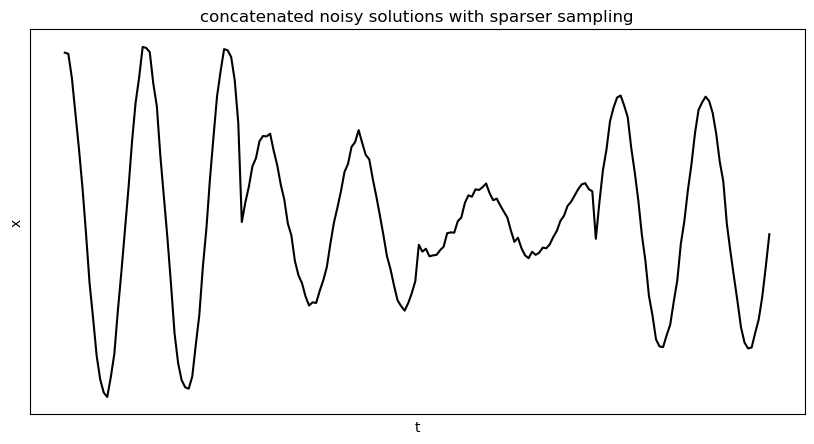

In [3]:
a = 0.3
b = 2.0
sols = []
sigma = 0.07
for initial_condition in initial_conditions:
    sols.append(odeint(diffyqs, initial_condition, t, args=(a,b))[:,1])
big_t = np.arange(0,4*tf,dt )#np.concatenate([t for i in range(4)])
big_sol = np.concatenate(sols)
sliced_sol = big_sol[0::4]
noisy_sliced_sol = sliced_sol + sigma * np.random.randn(len(sliced_sol))

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(noisy_sliced_sol, color = "black")
plt.title("concatenated noisy solutions with sparser sampling")
plt.xticks([])
plt.yticks([])
plt.grid()
plt.ylabel('x')
plt.xlabel('t')
plt.show()

# Running and saving

In [4]:
param_list = []
seeds = [0,1,2,3]
seeds = [1,2,3]
vbmc_count = 0
for nut in seeds:
    vbmc_count = 0
    for i,a in enumerate(a_vals): 
        b = b_vals[i]    
        param_list.append([a,b])

        # # get truth
        # sols = []
        # for initial_condition in initial_conditions:
        #     sols.append(odeint(diffyqs, initial_condition, t, args=(a,b))[:,1])

        # sigma = 0.12
        # big_sol = np.concatenate(sols)
        # sliced_sol = big_sol[0::4]
        # noisy_sliced_sol = sliced_sol + sigma * np.random.randn(len(sliced_sol))
        
        # # Do initial optimization to get an x0
        # np.random.seed(nut) # change this
        # x0 = minimize(
        #     lambda t: -log_likelihood(t),
        #     x0_rand,
        #     bounds=[
        #         (a_min, a_max),
        #         (b_min, b_max),
        #     ],
        # ).x

        # # run vbmc and save results
        # np.random.seed(nut) # and this
        # vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options)
        # np.random.seed(nut) # and this
        # vp, results = vbmc.optimize();
        # vbmc.vp.save("vp" + str(vbmc_count) + str(nut) + ".pkl", overwrite=True)
        # vbmc_count += 1

# save parameter values
#np.savetxt("param_values.csv", np.array(param_list))

# Reading everything back in

In [5]:
# reading in saved vps and their associated parameter values
param_values = np.loadtxt("param_values.csv")

vps0 = []
vps1 = []
vps2 = []
vps3 = []

for i in range(len(a_vals)):
    vps0.append(VariationalPosterior.load("vp" + str(i) + str(0) + ".pkl"))
    vps1.append(VariationalPosterior.load("vp" + str(i) + str(1) + ".pkl"))
    vps2.append(VariationalPosterior.load("vp" + str(i) + str(2) + ".pkl"))
    vps3.append(VariationalPosterior.load("vp" + str(i) + str(3) + ".pkl"))

In [11]:
moments0 = []
moments1 = []
moments2 = []
moments3 = []
for i in range(len(a_vals)):
    moments0.append(vps0[i].moments()[0])
    moments1.append(vps1[i].moments()[0])
    moments2.append(vps2[i].moments()[0])
    moments3.append(vps3[i].moments()[0])


# Visualization

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import scipy.integrate as integrate
    
def euclidean_metric(vp,truth_array, n_samples = int(1e6),original = False): 
    """
    Returns a measure of how close the actual parameters are to the estimated parameters,
    computed by finding the euclidean distance between the mean of a large sample of the 
    varaitional posterior and the true values of the parameters.

    vp: varational posterior from PyVBMC
    truth_array: numpy array of the true values of the parameters (must be in the same order as the vp returns!)

    set original to true to respect the original distances
    """
    Xs, _ = vp.sample(n_samples) # sample vp
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaler.fit(np.concatenate((Xs,truth_array)))                     # fit scaler to samples
    scaled_data = scaler.transform(np.concatenate((Xs,truth_array))) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    #print(mean,truth_scaled[0])
    if original:
        return np.linalg.norm(scaler.inverse_transform(mean-truth_scaled))
    else:
        return np.linalg.norm(mean-truth_scaled[0])

    
def get_box(vp,true_value, bounds = False):
    pdf_mean = vp.moments()
    real0 = true_value[0]
    real1 = true_value[1]
    x0 = pdf_mean[0,0]
    x1 = pdf_mean[0,1]
    d0 = abs(x0-real0)
    d1 = abs(x1-real1)
    bl = (x0 - d0, x1 - d1)
    br = (x0 + d0, x1 - d1)
    tl = (x0 - d0, x1 + d1)
    tr = (x0 + d0, x1 + d1)
    if bounds:
        x_lb = x0 - d0
        x_ub = x0 + d0
        y_lb = x1 - d1
        y_ub = x1 + d1
        return x_lb,x_ub, y_lb, y_ub
    else:
        return np.asarray([bl,br,tr,tl,bl])

def CI_2D(vp,pdf,true_value):
    x_lb,x_ub, y_lb, y_ub = get_box(vp,true_value, bounds=True)
    return integrate.dblquad(pdf, x_lb, x_ub, y_lb, y_ub)[0]

In [13]:
for i in range(len(a_vals)):
    print(param_list[i],np.around(moments0[i],2),np.around(moments1[i],2),np.around(moments2[i],2),np.around(moments3[i],2))

[0.06, 1.44] [0.06 1.47] [0.07 1.31] [0.06 1.51] [0.07 1.3 ]
[0.06, 5.0] [0.06 5.07] [0.06 5.01] [0.06 5.02] [0.06 4.97]
[0.5, 1.44] [0.5  1.44] [0.5  1.44] [0.5  1.44] [0.49 1.46]
[0.5, 5.0] [0.5 5. ] [0.5  5.01] [0.5 5. ] [0.51 4.98]
[0.28, 3.22] [0.28 3.24] [0.28 3.23] [0.28 3.21] [0.29 3.18]


In [102]:
euclidean_metrics0 = []
euclidean_metrics1 = []
euclidean_metrics2 = []
euclidean_metrics3 = []

for i in range(len(a_vals)):
    euclidean_metrics0.append(euclidean_metric(vps0[i],np.atleast_2d(param_list[i]),original=False))
    euclidean_metrics1.append(euclidean_metric(vps1[i],np.atleast_2d(param_list[i]),original=False))
    euclidean_metrics2.append(euclidean_metric(vps2[i],np.atleast_2d(param_list[i]),original=False))
    euclidean_metrics3.append(euclidean_metric(vps3[i],np.atleast_2d(param_list[i]),original=False))

for i in range(len(a_vals)):
    print(np.around(euclidean_metrics0[i],2),np.around(euclidean_metrics1[i],2),np.around(euclidean_metrics2[i],2),np.around(euclidean_metrics3[i],2))

0.08 0.39 0.21 0.33
1.02 0.29 0.09 0.22
0.06 0.1 0.02 0.27
0.1 0.13 0.09 0.36
0.2 0.32 0.08 0.49


In [120]:
df = pd.DataFrame([euclidean_metrics0,euclidean_metrics1,euclidean_metrics2,euclidean_metrics3]).T

df.columns = ["Euclid 0","Euclid 1", "Euclid 2", "Euclid 3"]

df

,Euclid 0,Euclid 1,Euclid 2,Euclid 3
0,0.080565,0.386171,0.207015,0.334240
1,1.017215,0.293593,0.094402,0.224412
2,0.060916,0.096222,0.020082,0.272647
3,0.103419,0.131185,0.091464,0.355205
4,0.199600,0.317586,0.078324,0.494167


In [86]:
df.corr()

,seed 0,seed 1,seed 2,seed 3
seed 0,1.000000,0.269268,-0.099046,-0.462237
seed 1,0.269268,1.000000,0.741724,0.202361
seed 2,-0.099046,0.741724,1.000000,0.023073
seed 3,-0.462237,0.202361,0.023073,1.000000


In [111]:
CI_metrics0 = []
CI_metrics1 = []
CI_metrics2 = []
CI_metrics3 = []

count = 0
print(count)
for i in range(len(a_vals)):
    pdf0 = lambda x,y: vps0[i].pdf(np.array([[y,x]]))
    pdf1 = lambda x,y: vps1[i].pdf(np.array([[y,x]]))
    pdf2 = lambda x,y: vps2[i].pdf(np.array([[y,x]]))
    pdf3 = lambda x,y: vps3[i].pdf(np.array([[y,x]]))
    CI_metrics0.append(CI_2D(vps0[i],pdf0,param_list[i]))
    count +=1
    print(count)
    CI_metrics1.append(CI_2D(vps1[i],pdf1,param_list[i]))
    count += 1
    print(count)
    CI_metrics2.append(CI_2D(vps2[i],pdf2,param_list[i]))
    count += 1
    print(count)
    CI_metrics3.append(CI_2D(vps3[i],pdf3,param_list[i]))
    count += 1
    print(count)

for i in range(len(a_vals)):
    print(np.around(CI_metrics0[i],2),np.around(CI_metrics1[i],2),np.around(CI_metrics2[i],2),np.around(CI_metrics3[i],2))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0.26 0.91 0.59 0.83
1.0 0.49 0.13 0.89
0.18 0.31 0.0 0.74
0.42 0.47 0.35 0.98
0.79 0.76 0.37 1.0


In [121]:
CI_df = pd.DataFrame([CI_metrics0,CI_metrics1,CI_metrics2,CI_metrics3]).T

CI_df.columns = ["CI 0","CI 1","CI 2", "CI 3"]
#CI_df.to_csv("CI_dataframe.csv")
CI_df

,CI 0,CI 1,CI 2,CI 3
0,0.259006,0.911658,0.590166,0.827555
1,1.000000,0.487620,0.127326,0.885913
2,0.182217,0.308178,0.003171,0.743419
3,0.419173,0.474697,0.345057,0.980609
4,0.793580,0.756923,0.374552,0.998876


In [113]:
CI_df.corr()

,seed 0,seed 1,seed 2,seed 3
seed 0,1.000000,0.057151,-0.129859,0.563306
seed 1,0.057151,1.000000,0.911476,0.284251
seed 2,-0.129859,0.911476,1.000000,0.391345
seed 3,0.563306,0.284251,0.391345,1.000000


In [88]:
# for i in range(len(a_vals)):
#     Xs0,_ = vps0[i].sample(int(5e5))
#     Xs2,_ = vps2[i].sample(int(5e5))
#     Xs3,_ = vps3[i].sample(int(5e5))
#     print(param_list[i])
#     plt.hist2d(Xs0[:,1],Xs0[:,0],bins = 100,cmap = "magma")
#     plt.show()
#     plt.hist2d(Xs2[:,1],Xs2[:,0],bins = 100,cmap = "magma")
#     plt.show()
    #plt.hist2d(Xs3[:,1],Xs3[:,0],bins = 100,cmap = "magma")
    #plt.show()

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

vp20 = vps0[2]
Xs,_ = vp20.sample(int(1e6))

df_for_regression = pd.DataFrame(Xs)
df_for_regression.columns = ['a','b']

X = df_for_regression['b']
y = df_for_regression['a']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = np.asarray(X_train).reshape(-1,1)
X_test = np.asarray(X_test).reshape(-1,1)

linear = LinearRegression()

linear.fit(X_train,y_train)

y_pred = linear.predict(X_test)

r2=metrics.r2_score(y_test, y_pred)
print('r2: ', round(r2,4))

truth = np.asarray(param_list[2])
some_bs = np.linspace(df_for_regression['b'].min(),df_for_regression['b'].max(),10)
some_as = linear.predict(some_bs.reshape(-1,1))

r2:  0.914


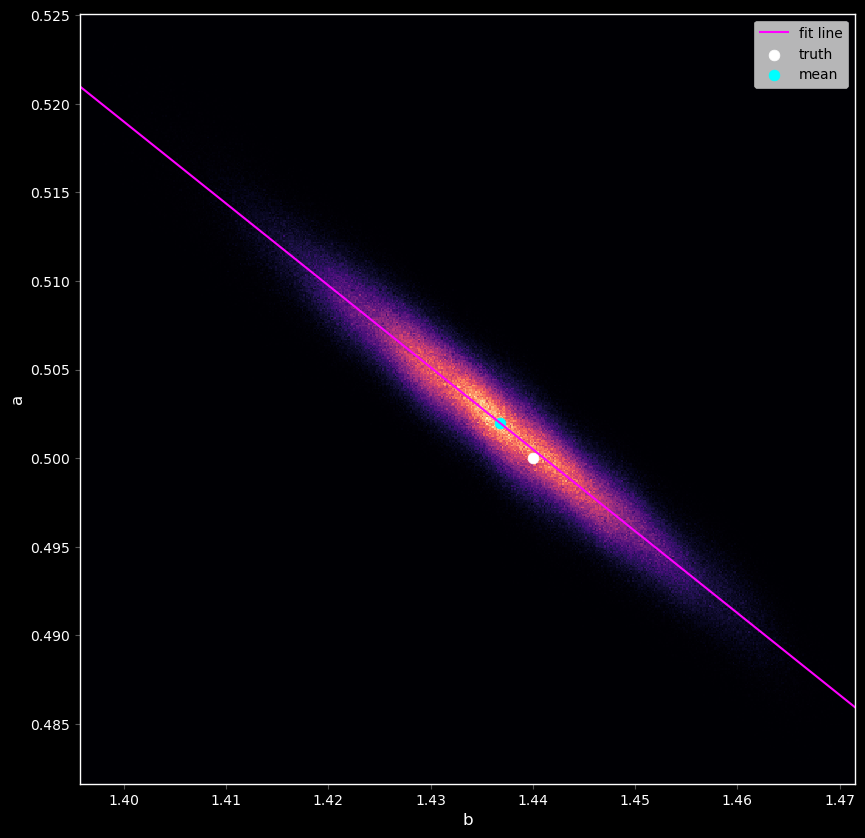

In [46]:
fig = plt.figure(figsize=(10,10))
fig.patch.set_facecolor('black')

plt.hist2d(Xs[:,1],Xs[:,0],bins = 500,cmap = "magma")
plt.plot(some_bs,some_as, c = "magenta", label = "fit line")
plt.scatter(truth[1], truth[0],s = 60, c = "w", label = "truth")
plt.scatter(Xs[:,1].mean(), Xs[:,0].mean(),s = 60, c = "cyan", label = "mean")
plt.xlabel("b", c = "w")
plt.xticks(c = "w")
plt.yticks(c = "w")
plt.ylabel('a', c = "w")
plt.legend()
#plt.axis('equal')
plt.show()

In [24]:
x = np.linspace(1.405, 1.46, num=100)
y = np.linspace(0.485, 0.515, num=100)
X, Y = np.meshgrid(x,y)

pdf = np.zeros(X.shape)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        pdf[i,j] = vp20.pdf([Y[i,j], X[i,j]])

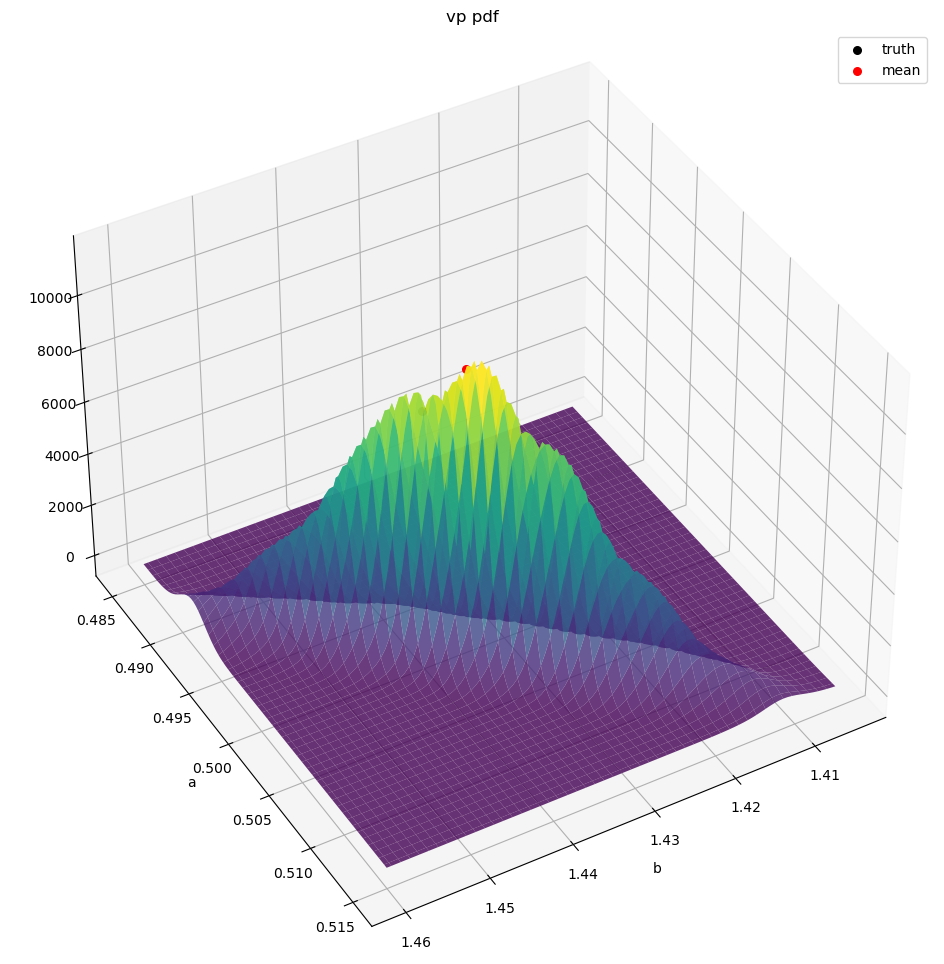

In [25]:
fig = plt.figure(figsize=(12,12))	
ax = fig.add_subplot(projection = '3d')
ax.view_init(40, 60)
ax.plot_surface(X, Y, pdf, cmap ='viridis', alpha = 0.8)
ax.scatter(truth[1],truth[0],vp20.pdf([truth[0],truth[1]]), c = "black", label = "truth",s = 30)
ax.scatter(Xs[:,1].mean(), Xs[:,0].mean(),vp20.pdf([Xs[:,0].mean(),Xs[:,1].mean()]), c = "red", label = "mean",s = 30)
ax.set_title("vp pdf")
plt.xlabel("b")
plt.ylabel("a")
#ax.axes.zaxis.set_ticks([])
ax.legend()

plt.show()

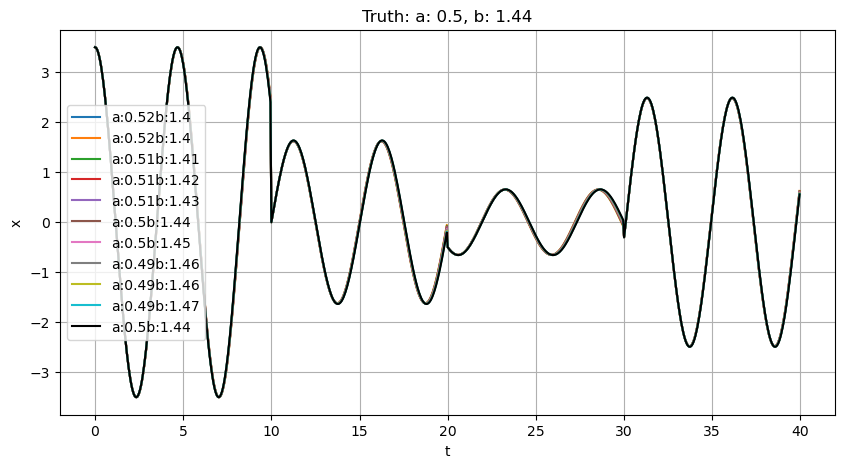

In [95]:
big_sols = []
sols = []
for initial_condition in initial_conditions:
    sols.append(odeint(diffyqs, initial_condition, t, args=(truth[0],truth[1]))[:,1])
big_sols.append(sols)

for i in range(len(some_bs)):
    sols = []
    a = some_as[i]
    b = some_bs[i]
    
    for initial_condition in initial_conditions:
        sols.append(odeint(diffyqs, initial_condition, t, args=(a,b))[:,1])
    
    big_sols.append(sols)

big_sols = np.asarray(big_sols)

plt.figure(figsize=(10,5))
for i,sols in enumerate(big_sols):

    sol = np.concatenate(sols)
    if i <= 9:
        plt.plot(big_t, sol,label = str("a:" + str(np.around(some_as[i],2)) + "b:" + str(np.around(some_bs[i],2))))
    else:
        plt.plot(big_t, sol,label = str("a:" + str(np.around(truth[0],2)) + "b:" + str(np.around(truth[1],2))), c = 'black')

plt.title("Truth: a: 0.5, b: 1.44")
plt.grid()
plt.ylabel('x')
plt.xlabel("t")
plt.legend()
plt.show()

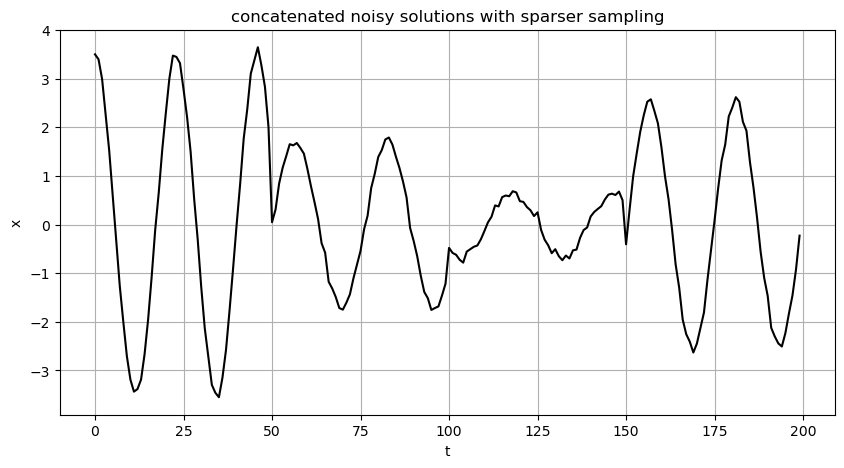

In [96]:
plt.figure(figsize=(10,5))
plt.plot(noisy_sliced_sol, color = "black")
plt.title("concatenated noisy solutions with sparser sampling")
plt.grid()
plt.ylabel('x')
plt.xlabel("t")
plt.show()

In [97]:
from scipy.stats import multivariate_normal
import sys
minp = sys.float_info.min
sigma_small = 0.01
truth = multivariate_normal(mean = np.array([0.5,10]), cov = np.array([[sigma_small,0],[0,sigma_small]]))
delta = truth.pdf

def truth_first_KL(true_posterior,vp2):  # KL[true posterior || vp2]
    xx1 = true_posterior.rvs(size = int(1e4))
    q1 = true_posterior.pdf(xx1)
    q2 = vp2.pdf(xx1)
    q1[q1 == 0 | np.isinf(q1)] = 1.0
    q2[q2 == 0 | np.isinf(q2)] = minp
    kl1 = -np.mean(np.log(q2) - np.log(q1))
    return np.maximum(0, kl1)

In [98]:
KL0 = []
KL1 = []
KL2 = []
KL3 = []

for i in range(len(a_vals)):
    truth = multivariate_normal(mean = param_list[i], cov = np.array([[sigma_small,0],[0,sigma_small]]))
    KL0.append(truth_first_KL(truth,vps0[i]))
    KL1.append(truth_first_KL(truth,vps1[i]))
    KL2.append(truth_first_KL(truth,vps2[i]))
    KL3.append(truth_first_KL(truth,vps3[i]))

for i in range(len(a_vals)):
    print(np.around(KL0[i],2),np.around(KL1[i],2),np.around(KL2[i],2),np.around(KL3[i],2))

556.4 541.62 559.76 528.12
707.89 705.77 202.28 699.44
507.23 538.6 530.34 551.69
695.99 693.79 694.17 697.95
662.62 681.7 657.66 663.78


In [122]:
KL_df = pd.DataFrame([KL0,KL1,KL2,KL3]).T

KL_df.columns = ["KL 0","KL 1","KL 2", "KL 3"]

KL_df

,KL 0,KL 1,KL 2,KL 3
0,556.400130,541.619012,559.762600,528.121838
1,707.892471,705.770074,202.281083,699.444072
2,507.227223,538.597073,530.344719,551.685886
3,695.985230,693.788119,694.165586,697.948348
4,662.620432,681.701575,657.664474,663.777055


In [100]:
KL_df.corr()

,seed 0,seed 1,seed 2,seed 3
seed 0,1.000000,0.978640,-0.183911,0.955221
seed 1,0.978640,1.000000,-0.158036,0.988746
seed 2,-0.183911,-0.158036,1.000000,-0.161753
seed 3,0.955221,0.988746,-0.161753,1.000000


<Axes: >

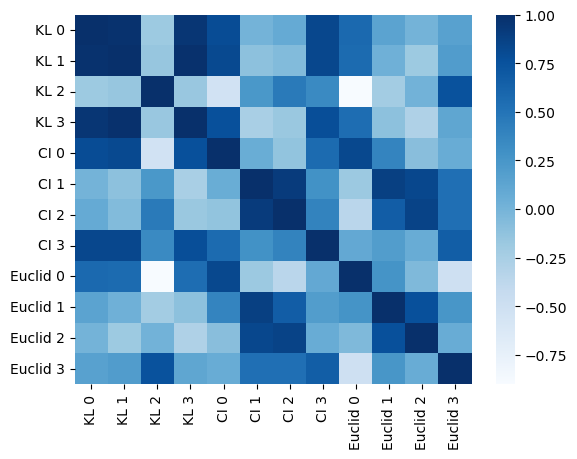

In [126]:
import seaborn as sns
colormap = sns.color_palette("Blues", as_cmap=True)
sns.heatmap(pd.concat((KL_df,CI_df,df), axis = 1,).corr(),cmap = colormap)

<Axes: title={'center': 'Correlation of metrics averaged across 4 seeds'}>

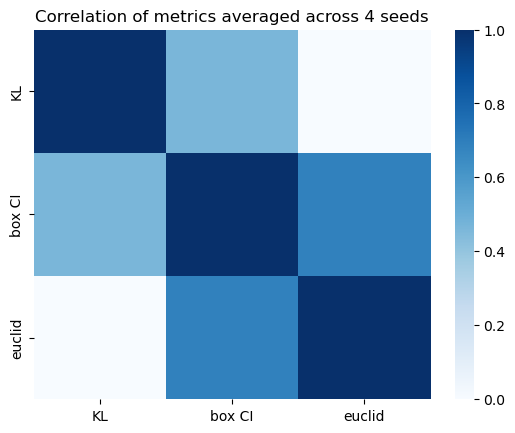

In [141]:
averaged_metrics = pd.DataFrame((KL_df.mean(axis = 1),CI_df.mean(axis = 1),df.mean(axis =1))).T
averaged_metrics.columns = ["KL", "box CI","euclid"]
plt.title("Correlation of metrics averaged across 4 seeds")
sns.heatmap(averaged_metrics.corr(),cmap = colormap)

In [142]:
averaged_metrics.corr()

,KL,box CI,euclid
KL,1.000000,0.460640,-0.001865
box CI,0.460640,1.000000,0.689502
euclid,-0.001865,0.689502,1.000000


In [18]:
import corner

In [47]:
truth[0]
moment = vp20.moments()[0]
Xs, _ = vp20.sample(int(1e6))

In [ ]:
from pyvbmc import VariationalPosterior

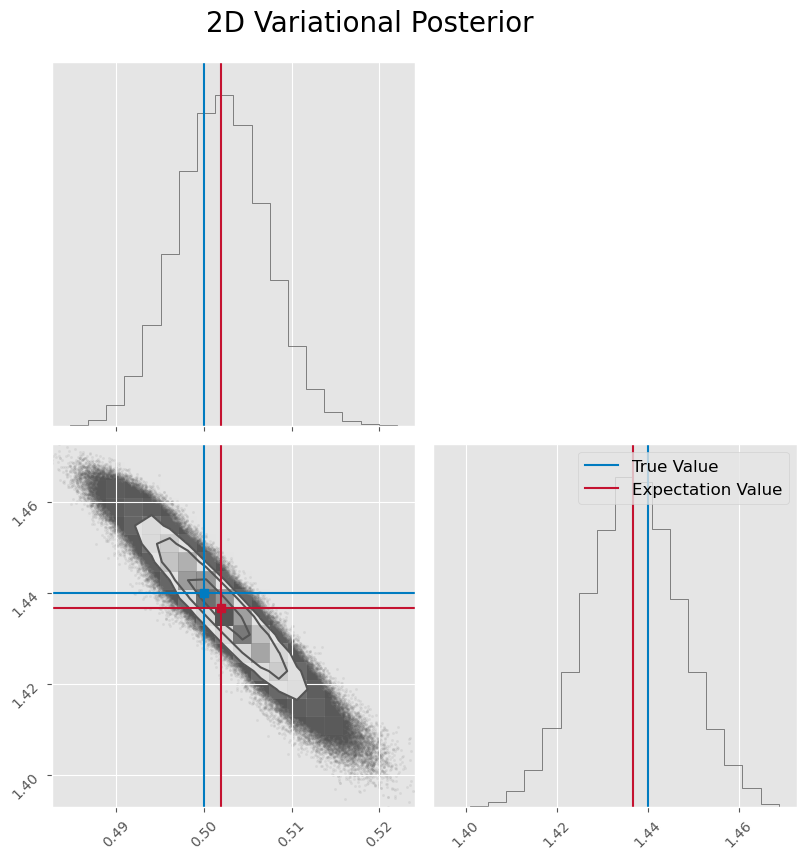

In [69]:
plt.style.use("ggplot")
# use red first, then blue then green for single plots
red = "#C41230"
blue  = "#007BC0"
green = "#009647"
fig = plt.figure(figsize=(10,10))
fig = corner.corner(Xs,fig = fig)

corner.overplot_lines(fig, truth, color=blue, label = "True Value")
corner.overplot_points(fig, truth[None], marker="s", color=blue)
corner.overplot_lines(fig, moment, color=red, label = "Expectation Value")
corner.overplot_points(fig, moment[None], marker="s", color=red)
plt.legend(loc = "upper right", fontsize = 12)
plt.suptitle('2D Variational Posterior', fontsize = 20)

plt.show()

In [60]:
from pyvbmc import VariationalPosterior
vp_3d = VariationalPosterior.load("3d_vp_reasonable.pkl")

truth2 = np.array([-2.89037176,3.,-1.64865863])

moment2 = vp_3d.moments()[0]
Xs2, _ = vp_3d.sample(int(1e6))

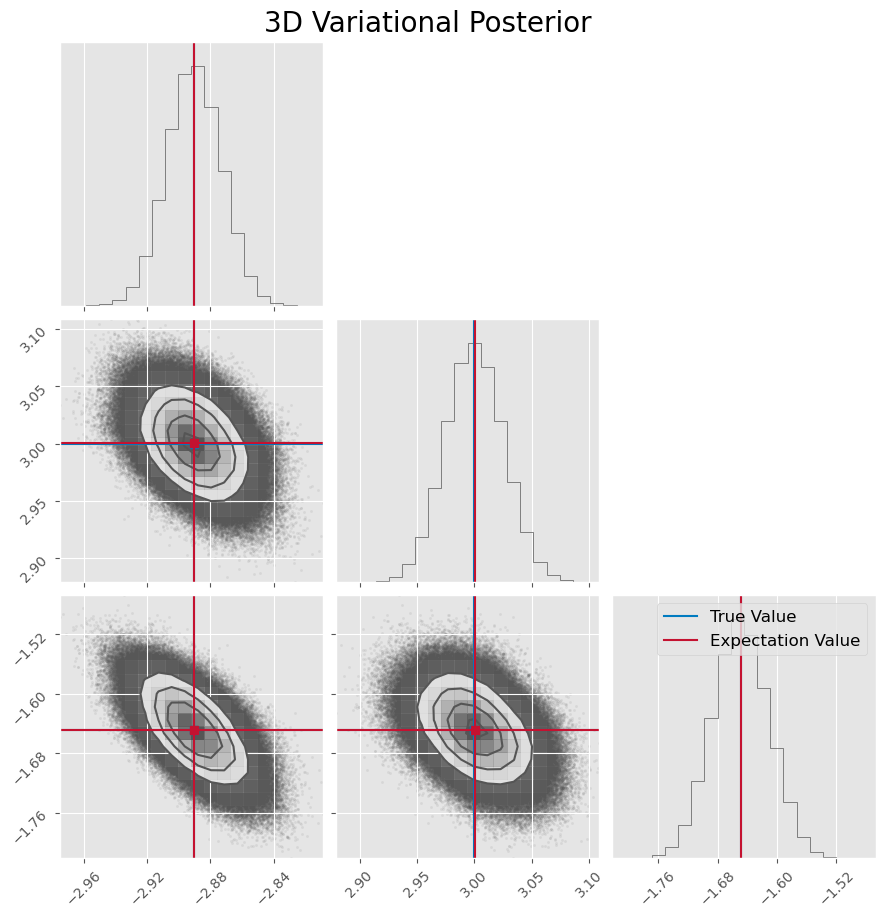

In [70]:
fig = plt.figure(figsize=(10,10))
fig = corner.corner(Xs2,fig = fig)

corner.overplot_lines(fig, truth2, color=blue, label = "True Value")
corner.overplot_points(fig, truth2[None], marker="s", color=blue)
corner.overplot_lines(fig, moment2, color=red, label = "Expectation Value")
corner.overplot_points(fig, moment2[None], marker="s", color=red)
plt.legend(loc = "upper right", fontsize = 12)
plt.suptitle('3D Variational Posterior', fontsize = 20)

plt.show()